<a href="https://colab.research.google.com/github/shajarian/Transformer/blob/main/Maybe_Final_Attempt_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May  2 03:08:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import re

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_location = "/content/drive/My Drive/data/"

MessageError: ignored

In [ ]:
questions_df = pd.read_csv(data_location + "Questions.csv",encoding='ISO-8859-1')
questions_df.drop(columns = ["CreationDate", "OwnerUserId", "ClosedDate"],inplace = True)
questions_df

In [ ]:
# filter out questions with score less than 10
min_score = 10
np.shape(questions_df[questions_df['Score']>min_score])

In [ ]:
# drop questions that have score less than 10
questions_df = questions_df[questions_df['Score']>min_score]
questions_df

In [ ]:
tags_df = pd.read_csv(data_location + "Tags.csv")
tags_df['Tag'] = tags_df['Tag'].astype(str) # Converting "Tag" values into string to make actions like appending easier
tags_df

In [ ]:
# Counting the number of unique tags
len(tags_df.Tag.unique())

In [ ]:
top_tags_number = 30
top_tags = tags_df['Tag'].value_counts().head(top_tags_number).index.tolist()
top_tags

In [ ]:
tags_df = tags_df[tags_df['Tag'].isin(top_tags)]
tags_df

In [ ]:
grouped_tags_df = tags_df.groupby('Id')['Tag'].apply(list).reset_index(name = "Tags")
grouped_tags_df

In [ ]:
# v = 99.85
# p = np.percentile(tag_counts, v)
# print(v, " percentile of arr : ", p)
# print(np.count_nonzero(tag_counts >= p))

Based on the graph, the threshold for cutting the data can be at around count of 18,000 which equals percentile 99.95 and leaves only 20 labels in our dataset. Since we want a higher number of labels, we will consider top-50 labels in tags dataset and remove the rest. This will help students find the most relevant categories or teachers categories the assignments in the meaningful groups.

In [ ]:
def preprocess_text(text):
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|\n', '', text)   # remove HTML tags
    text = re.sub(r'[^\w\s]','', text)  # remove punctuation marks
    Tidy_body = text.lower()
    return Tidy_body

questions_df['Tidy_body'] = questions_df['Body'].apply(preprocess_text)
questions_df.reset_index(inplace=True,drop=True)
questions_df

In [ ]:
questions_df = questions_df.merge(grouped_tags_df, on='Id')

In [ ]:
questions_df

In [ ]:
questions_df.Tags[0]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(questions_df.Tags)

In [ ]:
mlb.classes_

In [ ]:
questions_df['Binarized_Tags'] = list(tag_matrix)
questions_df

In [ ]:
import matplotlib.pyplot as plt

# create example dataframe
df = questions_df

# filter rows with list of more than one element
df_filtered = df[df['Tags'].apply(lambda x: len(x) > 1)]

# plot count of sizes more than one
sizes = df_filtered['Tags'].apply(len)
sizes_counts = sizes.value_counts()
sizes_counts.plot(kind='bar')
plt.xlabel('List size')
plt.ylabel('Count')
plt.title('Count of list sizes more than one')
plt.show()

In [ ]:
questions_df.drop(columns = ["Id", "Score", "Title","Body"],inplace = True)
questions_df

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# compute no. of words in each question
questions = questions_df.Tidy_body
word_cnt = [len(quest) for quest in questions]

# Plot the distribution
plt.figure(figsize=[8,5])
n, bins, patches = plt.hist(word_cnt, bins = 4 * 13) # the highest number of tokens in a question is 13368--so we choose the n*13 as the no. of bins to the bin range
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurrences')
plt.title("Frequency of Word Counts/sentence")

# Add count values to top of each bar
for i, patch in enumerate(patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, int(n[i]), ha='center', va='bottom')

plt.show()

In [ ]:
# from wordcloud import WordCloud
# tag_to_count_map
# tupl = dict(tag_to_count_map.items())
# word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
# plt.figure(figsize = (12,8))
# plt.imshow(word_cloud)
# plt.axis('off')
# plt.tight_layout(pad=0)

In [ ]:
# Hyperparameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 1e-5

In [ ]:
# Import tokenizer
!pip install transformers
from transformers import BertTokenizer, BertModel

In [ ]:
# We use BERT-base and as in our context the upper case is not important, we use uncased
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Based on this plot, it can be seen that the maximum number of 500 tokens encompass most of questions.

In [ ]:
questions_df["Binarized_Tags"]

The tokenizer.encode_plus function combines multiple steps for us:


*   Split the sentence into tokens.
*   Add the special [CLS] and [SEP] tokens.
*   Map the tokens to their IDs.
*   Pad or truncate all sentences to the same length.
*   Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.







In [ ]:
# Preprocess data for BERT and prepare DataLoader
import torch

class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.title = df.Tidy_body
        self.targets = df.Binarized_Tags
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }


We Divide up our training set to use 80% for training and 20% for validation and test.

In [ ]:
# Dataset Split
train_size = 0.8

train_df = questions_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
remaining_df = questions_df.drop(train_df.index).reset_index(drop=True)
val_df = remaining_df.sample(frac=0.5, random_state=200).reset_index(drop=True)
test_df = remaining_df.drop(val_df.index).reset_index(drop=True)

In [ ]:
len(train_df) ,len(val_df), len(test_df)

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

The DataLoader is responsible for providing batches of data during training.

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

The shape of the tensor is typically (batch_size, sequence_length), where batch_size is the number of samples in a batch and sequence_length is the length of the padded or truncated input sequences.

In [ ]:
a=next(iter(train_data_loader))
a['input_ids'].shape

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device


  This is one of the important part of this code. Hence I explain it step-by-step.
*   BERTClass is defined as a subclass of nn.Module, which is the base class for all neural network modules in PyTorch.
* In the __init__ method, super(BERTClass, self).__init__() calls the constructor of the base class nn.Module.
* The BERT model is loaded from the 'bert-base-uncased' pre-trained weights using the BertModel.from_pretrained() method, with the return_dict argument set to True. This means the model will return its outputs as a dictionary instead of a tuple.
* A dropout layer with a 0.3 dropout rate is added to the model.
* A linear layer is added to the model, which takes the BERT model's hidden layer representation of size 768 as input and outputs a vector of size top_tags_number for multi-label classification.
* The forward method takes input_ids, attn_mask, and token_type_ids as input and passes them through the BERT model.
* The output of the BERT model is a dictionary, and the pooled output representation (corresponding to the [CLS] token) is passed through the dropout layer.
* The output of the dropout layer is passed through the linear layer, which produces the final output of the model.

In [ ]:
# Define model and train
import torch.nn as nn

class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True) # sets the return_dict flag to True, so that the model outputs are returned as a dictionary instead of a tuple.
        self.dropout = torch.nn.Dropout(0.4)
        self.linear = torch.nn.Linear(768, top_tags_number) # 768 is the size of the hidden layer representations in the transformer network.

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output) #this is a pooler output
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

We chose BCEWithLogitsLoss because it stands for Binary Cross-Entropy with Logits Loss. This loss function is suitable for multi-label classification tasks where each label can be either 0 or 1, and the model should predict probabilities for each label independently. It combines a sigmoid activation function and the binary cross-entropy loss in a single class. This is more numerically stable than using a separate sigmoid activation followed by a binary cross-entropy loss

In [ ]:
# Define loss function using logits loss (combination of Binary Cross Entropy)
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = EPOCHS
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_data_loader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
# import numpy as np

# # Function to calculate the accuracy of our predictions vs targets
# def flat_accuracy(preds, targets):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     targets_flat = targets.flatten()
#     return np.sum(pred_flat == targets_flat) / len(targets_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# training loop
import random
import numpy as np

seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
valid_loss_min = np.Inf

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    train_loss = 0
    model.train() # tell the model that we are in training mode

    for index, batch in enumerate(train_data_loader):
      # Progress update every 40 batches.
        if index % 40 == 0 and not index == 0:
          elapsed = format_time(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(index, len(train_data_loader), elapsed))

        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.float)
        outputs = model(input_ids, attention_mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward() #calculate gradients
      # for name, param in model.named_parameters():
      #     if param.grad is not None:
      #         print(name, param.grad.data.norm(2).item())
        # Gradient cliping: This is a technique to prevent "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() # update rules (how parameters would be modified based on gradients, learning rate and so on)
        scheduler.step()
        train_loss += loss.item()

    train_loss /= len(train_data_loader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  training loss: {0:.2f}".format(train_loss))
    print("  Training epcoh took: {:}".format(training_time))


# Validation loop
    print("")
    print("Running Validation...")
    t0 = time.time()
    valid_loss = 0
    model.eval() # we are doing evaluation now!

    with torch.no_grad():
      for index, batch in enumerate(val_data_loader): # each batch cointains 32 examples corresponding input ids, attention, token
          input_ids = batch['input_ids'].to(device, dtype = torch.long)
          attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
          token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
          targets = batch['targets'].to(device, dtype = torch.float)
          outputs = model(input_ids, attention_mask, token_type_ids)
          loss = loss_fn(outputs, targets)
          valid_loss += loss.item()

      valid_loss /= len(val_data_loader)
      validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(valid_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': train_loss,
            'Valid. Loss': valid_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  1,189.    Elapsed: 0:00:02.
bert_model.embeddings.word_embeddings.weight 0.06225099787116051
bert_model.embeddings.position_embeddings.weight 0.054681554436683655
bert_model.embeddings.token_type_embeddings.weight 0.2115832269191742
bert_model.embeddings.LayerNorm.weight 0.020112715661525726
bert_model.embeddings.LayerNorm.bias 0.01539535354822874
bert_model.encoder.layer.0.attention.self.query.weight 0.021729519590735435
bert_model.encoder.layer.0.attention.self.query.bias 0.001712016761302948
bert_model.encoder.layer.0.attention.self.key.weight 0.020216593518853188
bert_model.encoder.layer.0.attention.self.key.bias 3.840443241198699e-10
bert_model.encoder.layer.0.attention.self.value.weight 0.069302037358284
bert_model.encoder.layer.0.attention.self.value.bias 0.014064876362681389
bert_model.encoder.layer.0.attention.output.dense.weight 0.04588440805673599
bert_model.encoder.layer.0.attention.output.dense.bias 0.0113524012

KeyboardInterrupt: ignored

In [ ]:
# # training loop
# # Set the seed value all over the place to make this reproducible.
# import random
# import numpy as np
# from sklearn import metrics
# from tqdm import tqdm, trange

# seed_val = 2023
# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# # We'll store a number of quantities such as training and validation loss,
# # validation accuracy, and timings.
# training_stats = []

# # Measure the total training time for the whole run.
# total_t0 = time.time()

# # This is a function called train_model that trains a deep learning model using a training loop. The function takes in several arguments including the number of epochs (n_epochs), training and validation data loaders (training_loader and validation_loader), the model architecture (model), optimizer (optimizer), and file paths for checkpointing (checkpoint_path and best_model_path).

# # The function starts by initializing a variable valid_loss_min with a very large value (infinity) to track the minimum validation loss. Then, the function loops through each epoch, where for each epoch, it loops through each batch of data in the training data loader and performs the forward and backward passes to update the model's parameters.
# # After the training loop for each epoch is completed, the function loops through each batch of data in the validation data loader and calculates the validation loss, which is used to monitor the model's performance.

# # def train_model(n_epochs, training_loader, validation_loader, model,
# #                 optimizer, checkpoint_path, best_model_path): #file paths for checkpointing

#   # initialize tracker with the maximum positive value to track the minimum validation loss

#   #valid_loss_min = np.Inf

# tr_loss = 0.0
# tr_step = 0.0
# for epoch_i in range(0, epochs):
#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')
#     #initially train and validation loss are zero.
#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     model.train() # tell the model that we are in training mode

#     for index, batch in enumerate(train_data_loader): # each batch cointains 32 examples corresponding input ids, attention, token
#       # Progress update every 40 batches.
#       if index % 40 == 0 and not index == 0:
#         elapsed = format_time(time.time() - t0)
#          # Report progress.
#         print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(index, len(train_data_loader), elapsed))

#         input_ids = batch['input_ids'].to(device, dtype = torch.long)
#         attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
#         token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
#         targets = batch['targets'].to(device, dtype = torch.float)
#         outputs = model(input_ids, attention_mask, token_type_ids)
#         optimizer.zero_grad()
#         loss = loss_fn(outputs, targets)
#         optimizer.zero_grad()
#         loss.backward() #calculate gradients
#         # Gradient cliping: This is a technique to prevent "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step() # update rules (how parameters would be modified based on gradients, learning rate and so on)
#         scheduler.step() #update the learning rate
#         tr_loss += loss.item()
#         tr_step += 1
#         # Measure how long this epoch took.
#         training_time = format_time(time.time() - t0)

#         print("")
#         print("  training loss: {0:.2f}".format(tr_loss))
#         print("  Training epcoh took: {:}".format(training_time))


# # Validation loop
#     print("")
#     print("Running Validation...")
#     t0 = time.time()
#     model.eval() # we are doing evaluation now!
#     preds=[]
#     label_ids=[]
#     with torch.no_grad():
#       for index, batch in enumerate(val_data_loader): # each batch cointains 32 examples corresponding input ids, attention, token
#         input_ids = batch['input_ids'].to(device, dtype = torch.long)
#         attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
#         token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
#         targets = batch['targets'].to(device, dtype = torch.float)
#         outputs = model(input_ids, attention_mask, token_type_ids)

#         preds.extend(torch.sigmoid(outputs).detach().cpu().numpy().tolist())
#         label_ids.extend(targets.detach().cpu().numpy().tolist())

#         preds_out = np.array(preds)>=0.5


#     #     # Move logits and labels to CPU
#     #     logits = logits.detach().cpu().numpy()
#     #     label_ids = b_labels.to('cpu').numpy()

#     #     # Calculate the accuracy for this batch of test sentences, and
#     #     # accumulate it over all batches.
#     #     total_eval_accuracy += flat_accuracy(logits, label_ids)


#     # # Report the final accuracy for this validation run.
#     # avg_val_accuracy = total_eval_accuracy / len(val_data_loader)
#     # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

#     # # Calculate the average loss over all of the batches.
#     # avg_val_loss = total_eval_loss / len(val_data_loader)

#     #      # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)

#     # print("  Validation Loss: {0:.2f}".format(val_loss))
#     # print("  Validation took: {:}".format(validation_time))

#       # create checkpoint variable and add important data
#       #For each epoch, the function creates a dictionary called checkpoint that contains the epoch number, current validation loss, model's state dictionary, and optimizer's state dictionary.
#       #The checkpoint dictionary is used for saving the model's state at certain intervals (called checkpointing), which allows for resuming training from a specific epoch and avoiding loss of progress due to interruptions.
#        # Record all statistics from this epoch.

#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': tr_loss,
#             #'Valid. Loss': val_loss,
#             #'Valid. Accur.': avg_val_accuracy,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )

# # The line of code you have provided calculates the accuracy score of the predicted labels (preds_out) compared to the true labels (label_ids) using scikit-learn's accuracy_score function from the metrics module.

# #The accuracy_score function takes two parameters: the true labels and the predicted labels, in that order. It then returns the accuracy score, which is the proportion of correct predictions out of all predictions made.

# #So, the variable accuracy will contain the accuracy score of the model's predictions on the given dataset. This is a commonly used evaluation metric for classification tasks.
#     accuracy = metrics.accuracy_score(label_ids, preds_out)
#     F1_score_micro = metrics.f1_score(label_ids,preds_out, average='micro',zero_division=0)
#     F1_score_macro = metrics.f1_score(label_ids,preds_out, average='macro',zero_division=0)



#     print(f'tain_loss={tr_loss/tr_step}')
#     print(f'Accuracy={accuracy}')
#     print(f'F1_Score_Micro={F1_score_micro}')
#     print(f'F1_Score_Macro={F1_score_macro}')


# print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


#    # The function also has commented out code that saves the checkpoint and best model if the validation loss decreases.
#    # This is a common technique called early stopping, which stops training the model when the validation loss stops improving to avoid overfitting. However, in the current implementation, this code is commented out and not used.

#     #   ## TODO: save the model if validation loss has decreased
#     #   if valid_loss <= valid_loss_min:
#     #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
#     #     # save checkpoint as best model
#     #     save_ckp(checkpoint, True, checkpoint_path, best_model_path)
#     #     valid_loss_min = valid_loss

#     # print('############# Epoch {}  Done   #############\n'.format(epoch))

Using word embeddings for converting tags to numeric values is not possible, since many tags are technical words without any numeric representation.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.07,1.33e-03,0:02:09,0:01:20
2,0.04,1.05e-03,0:01:55,0:01:23


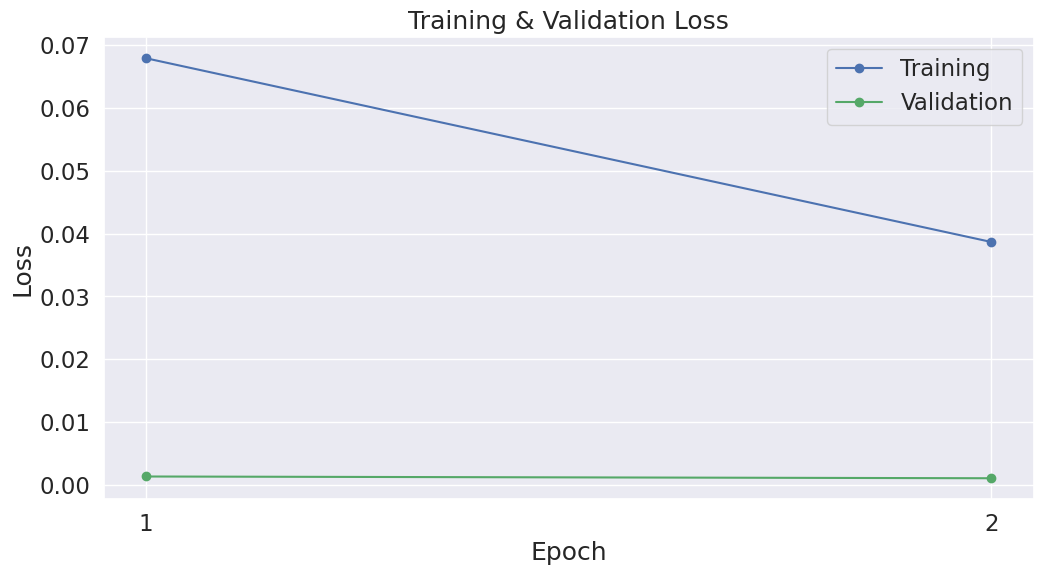

In [ ]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

In [ ]:
example = test_df['Tidy_body'][2374]
example

'note this is symfony  26 but i believe the same overall issue applies regardless of versionto start consider this form type that is designed to represent oneormore entities as a hidden field namespace stuff omitted for brevityclass hiddenentitytype extends abstracttype          var entitymanager         protected em    public function __constructentitymanager em            thisem  em        public function buildformformbuilderinterface builder array options            if optionsmultiple             builderaddviewtransformer                new entitiestoprimarykeystransformer                    thisemgetrepositoryoptionsclass                    optionsget_pk_callback                    optionsidentifier                                     else             builderaddviewtransformer                new entitytoprimarykeytransformer                    thisemgetrepositoryoptionsclass                    optionsget_pk_callback                                                  see class docbloc

In [ ]:
test_df

,Tidy_body,Tags,Binarized_Tags
0,im creating a simple rest application with dro...,[java],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,im using spring springdatajpa and find myself...,[java],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,i got one problem and i have described it belo...,"[ios, iphone, objective-c]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
3,can any one tell me what is a the best way to ...,[java],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,why does the code below crash the net compiler...,[c#],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
2372,filtering rows in a particular column are easy...,[c#],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2373,im testing a method that manipulates a collect...,[c#],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2374,note this is symfony 26 but i believe the sam...,[php],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2375,i have the following example codeclass a p...,[c++],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [ ]:
# testing
#tokenize test
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
#before predicting we should set eval model
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    # Now we have 768 outputs, sigmoid
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print (final_output)
    print(mlb.classes_[np.argmax(final_output, axis=1)])


[[0.17071707546710968, 0.19788900017738342, 0.21107731759548187, 0.15182703733444214, 0.16406583786010742, 0.2088538408279419, 0.1630168855190277, 0.17239728569984436, 0.20080435276031494, 0.18382464349269867, 0.1743704080581665, 0.15247520804405212, 0.20041188597679138, 0.2146158218383789, 0.22487105429172516, 0.21170394122600555, 0.1931118667125702, 0.14756499230861664, 0.16436760127544403, 0.13168522715568542, 0.18709668517112732, 0.16109640896320343, 0.21007110178470612, 0.16722731292247772, 0.18607808649539948, 0.24415501952171326, 0.1626816987991333, 0.18970374763011932, 0.21194742619991302, 0.1679966300725937]]
['ruby']


In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from gensim.models import KeyedVectors

# # Load the pre-trained word2vec model
# model = KeyedVectors.load_word2vec_format(data_location + "GoogleNews-vectors-negative300.bin.gz", binary=True)

# # Normalize the data
# tag_vectors_scaled = StandardScaler().fit_transform(tag_vectors)

# # apply DBSCAN to cluster the vectors
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# clusters = dbscan.fit_predict(tag_vectors_scaled)

# # assign each tag to its corresponding cluster
# df["Cluster"] = np.where(np.array(clusters) == -1, "Noise", clusters)

# # print the number of clusters and their sizes
# print("Number of clusters:", len(np.unique(clusters))-1) # exclude the noise cluster
# print("Cluster sizes:", df.groupby("Cluster").size())

# unique_tags = tags_df["Tag"].unique()
# tag_vectors = []
# for tag in unique_tags:
#     try:
#         tag_vec = model[tag]
#         tag_vectors.append(tag_vec)
#     except KeyError:
#         # handle tags that are not in the vocabulary of the model
#         print(tag)
#         pass

# df = pd.DataFrame(data = {'tags': unique_tags, 'word2vec presentation': tag_vectors})